In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
# from tensorflow.keras.layers import Input, Dense, LeakyReLU
# from tensorflow.keras.layers import Dropout 
# from sklearn.model_selection import train_test_split


# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import time
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, Reshape, concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt


In [ ]:
class IDS_CLASS:
            
    def read_KDD(self):
        cols ="""duration,
        protocol_type,
        service,
        flag,
        src_bytes,
        dst_bytes,
        land,
        wrong_fragment,
        urgent,
        hot,
        num_failed_logins,
        logged_in,
        num_compromised,
        root_shell,
        su_attempted,
        num_root,
        num_file_creations,
        num_shells,
        num_access_files,
        num_outbound_cmds,
        is_host_login,
        is_guest_login,
        count,
        srv_count,
        serror_rate,
        srv_serror_rate,
        rerror_rate,
        srv_rerror_rate,
        same_srv_rate,
        diff_srv_rate,
        srv_diff_host_rate,
        dst_host_count,
        dst_host_srv_count,
        dst_host_same_srv_rate,
        dst_host_diff_srv_rate,
        dst_host_same_src_port_rate,
        dst_host_srv_diff_host_rate,
        dst_host_serror_rate,
        dst_host_srv_serror_rate,
        dst_host_rerror_rate,
        dst_host_srv_rerror_rate"""

        columns =[]
        for c in cols.split(',\n'):
            if(c.strip()):
                columns.append(c.strip())
        columns.append('target')
        print('Number of columns in dataset: ',len(columns))
        
        attacks_types = {
            'normal': 'normal',
        'back': 'dos',
        'buffer_overflow': 'u2r',
        'ftp_write': 'r2l',
        'guess_passwd': 'r2l',
        'imap': 'r2l',
        'ipsweep': 'probe',
        'land': 'dos',
        'loadmodule': 'u2r',
        'multihop': 'r2l',
        'neptune': 'dos',
        'nmap': 'probe',
        'perl': 'u2r',
        'phf': 'r2l',
        'pod': 'dos',
        'portsweep': 'probe',
        'rootkit': 'u2r',
        'satan': 'probe',
        'smurf': 'dos',
        'spy': 'r2l',
        'teardrop': 'dos',
        'warezclient': 'r2l',
        'warezmaster': 'r2l',
        }
        
        path = "/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent.gz"        
        # self.df = pd.read_csv(path, names = columns)
        self.df = pd.read_csv("kddcup.data_10_percent.gz", names = columns)
        # Adding Attack Type column
        self.df['Attack Type'] = self.df.target.apply(lambda r:attacks_types[r[:-1]])
        display(self.df.head())




    def preprocess_dataset(self):
        self.eval_list = []
        
        display(self.df.shape)
        display(self.df.isnull().sum())
        
        # Finding categorical features
        num_cols = self.df._get_numeric_data().columns
        cate_cols = list(set(self.df.columns)-set(num_cols))
        cate_cols.remove('target')
        cate_cols.remove('Attack Type')
        display(cate_cols)        
        
        self.feature_selection()
        self.feature_mapping()
        self.split_scale()




    def feature_selection(self):        
        # drop columns with NaN
        self.df = self.df.dropna(axis='columns')

        # keep columns where there are more than 1 unique values and are numeric
        ndf = self.df[[col for col in self.df.columns if self.df[col].nunique() > 1 and pd.api.types.is_numeric_dtype(self.df[col])]]
        # Now calculate the correlation matrix
        corr = ndf.corr()
        plt.figure(figsize =(15, 12))
        sns.heatmap(corr)
        plt.show()
        
        # This variable is highly correlated with num_compromised and should be ignored for analysis.
        #(Correlation = 0.9938277978738366)
        self.df.drop('num_root', axis = 1, inplace = True)

        # This variable is highly correlated with serror_rate and should be ignored for analysis.
        #(Correlation = 0.9983615072725952)
        self.df.drop('srv_serror_rate', axis = 1, inplace = True)

        # This variable is highly correlated with rerror_rate and should be ignored for analysis.
        #(Correlation = 0.9947309539817937)
        self.df.drop('srv_rerror_rate', axis = 1, inplace = True)

        # This variable is highly correlated with srv_serror_rate and should be ignored for analysis.
        #(Correlation = 0.9993041091850098)
        self.df.drop('dst_host_srv_serror_rate', axis = 1, inplace = True)

        # This variable is highly correlated with rerror_rate and should be ignored for analysis.
        #(Correlation = 0.9869947924956001)
        self.df.drop('dst_host_serror_rate', axis = 1, inplace = True)

        # This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
        #(Correlation = 0.9821663427308375)
        self.df.drop('dst_host_rerror_rate', axis = 1, inplace = True)

        # This variable is highly correlated with rerror_rate and should be ignored for analysis.
        #(Correlation = 0.9851995540751249)
        self.df.drop('dst_host_srv_rerror_rate', axis = 1, inplace = True)

        # This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
        #(Correlation = 0.9865705438845669)
        self.df.drop('dst_host_same_srv_rate', axis = 1, inplace = True)
        
        # --- drop unnecessary column ---
        self.df.drop('service', axis = 1, inplace = True)
        self.df = self.df.drop(['target', ], axis = 1)

        
        
        
    def feature_mapping(self):
        # protocol_type feature mapping
        pmap = {'icmp':0, 'tcp':1, 'udp':2}
        self.df['protocol_type'] = self.df['protocol_type'].map(pmap)
        
        # flag feature mapping
        fmap = {'SF':0, 'S0':1, 'REJ':2, 'RSTR':3, 'RSTO':4, 'SH':5, 'S1':6, 'S2':7, 'RSTOS0':8, 'S3':9, 'OTH':10}
        self.df['flag'] = self.df['flag'].map(fmap)
        
        
    
    
    
    def split_scale(self, test_size = 0.33):
        self.test_size = test_size
        
        # Splitting the dataset
        print('df shape:',self.df.shape)

        # Target variable and train set
        y = self.df[['Attack Type']]
        X = self.df.drop(['Attack Type', ], axis = 1)

        sc = MinMaxScaler()
        X = sc.fit_transform(X)

        # Split test and train data 
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = self.test_size, random_state = 42)
        print('X_train shape:',self.X_train.shape, '\t X_test shape:',self.X_test.shape)
        print('y_train shape:',self.y_train.shape, '\t y_test shape:',self.y_test.shape)

    
    
    
    
    
    def eval_model(self, model=-1, model_name="model_name"):
        if model == -1:
            self.model = GaussianNB()
            model_name = 'GB'
        else:
            self.model = model
            
        print('\n\nModel:', model_name)
        
        start_time = time.time()
        self.model.fit(self.X_train, self.y_train.values.ravel())
        end_time = time.time()
        print("Training time: ", end_time-start_time)

        start_time2 = time.time()
        y_test_pred = self.model.predict(self.X_train)
        end_time2 = time.time()
        print("Testing time: ", end_time2-start_time2)
        
        print("Train score is:", self.model.score(self.X_train, self.y_train))
        print("Test score is:", self.model.score(self.X_test, self.y_test))            
        self.eval_list.append([model_name, 
                               end_time-start_time, 
                               end_time2-start_time2 , 
                               self.model.score(self.X_train, self.y_train), 
                               self.model.score(self.X_test, self.y_test)])
                

    
    
    
    def eval_graph(self):
        # index = ['model_name', 'training-time', 'testing-time', 'tain-score', 'test-score']        
        titles = ['training-time', 'testing-time', 'tain-score', 'test-score']
        print("\n\n ")
        print(self.eval_list)        
        fig, axs = plt.subplots(len(titles), 1, figsize =(15, 25))        
        for j in range( len(titles) ):
            names = [ i[0] for i in self.eval_list ]
            values = [ i[j] for i in self.eval_list ]            
            axs[j].set_title(f'DL model Vs {titles[j]}')
            axs[j].bar(names, values)
            print(names)
            print(values)
        

        
obj = IDS_CLASS()

Number of columns in dataset:  42


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


(494021, 43)

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

['service', 'flag', 'protocol_type']

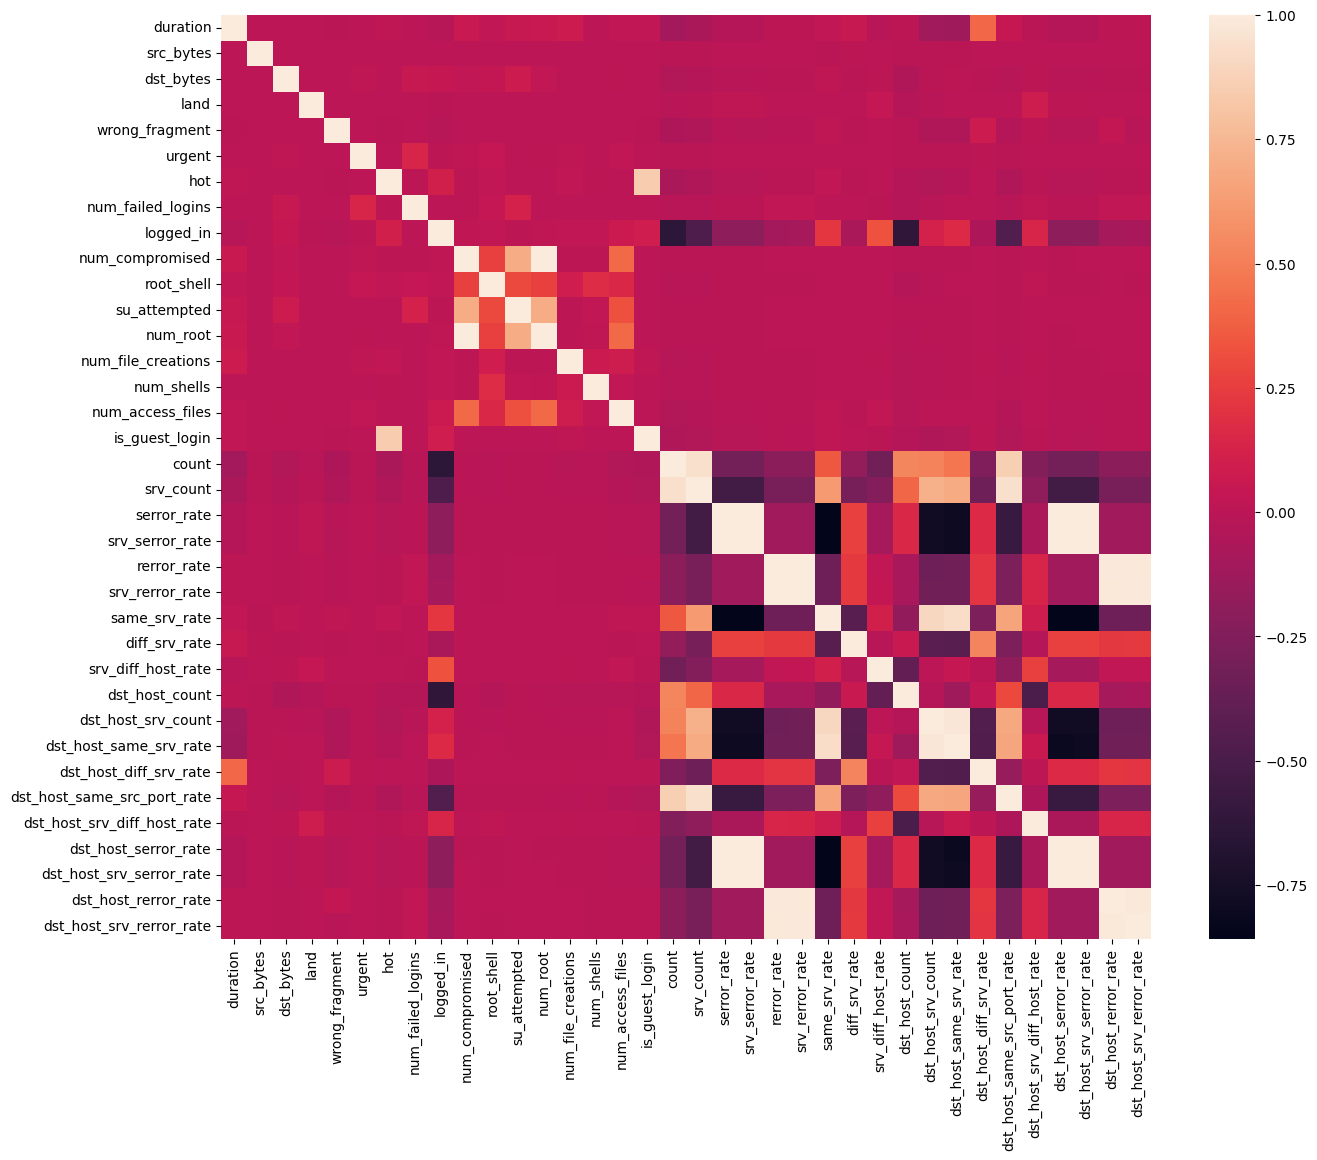

df shape: (494021, 33)
X_train shape: (330994, 32) 	 X_test shape: (163027, 32)
y_train shape: (330994, 1) 	 y_test shape: (163027, 1)


In [24]:
obj.read_KDD()
obj.preprocess_dataset()

In [25]:
# obj.eval_model()
# obj.eval_graph()



Model: GNB
Training time:  0.48035192489624023
Testing time:  0.6653385162353516
Train score is: 0.8795114110829804
Test score is: 0.8790384414851528


Model: DT
Training time:  0.9718778133392334
Testing time:  0.04122471809387207
Train score is: 0.9939424883834752
Test score is: 0.9938476448686414


Model: RF
Training time:  7.381298065185547
Testing time:  0.5923821926116943
Train score is: 0.9999939575943975
Test score is: 0.9997485079158667


Model: SVC
Training time:  331.13692688941956
Testing time:  101.57856106758118
Train score is: 0.9987462008374774
Test score is: 0.9987854772522343


Model: LR
Training time:  5.519566535949707
Testing time:  0.06517362594604492
Train score is: 0.9935044139772926
Test score is: 0.9934796076723488


Model: GBC
Training time:  359.6280915737152
Testing time:  2.435347318649292
Train score is: 0.9991389572016411
Test score is: 0.9990553711961823


 
[['GNB', 0.48035192489624023, 0.6653385162353516, 0.8795114110829804, 0.8790384414851528], ['D

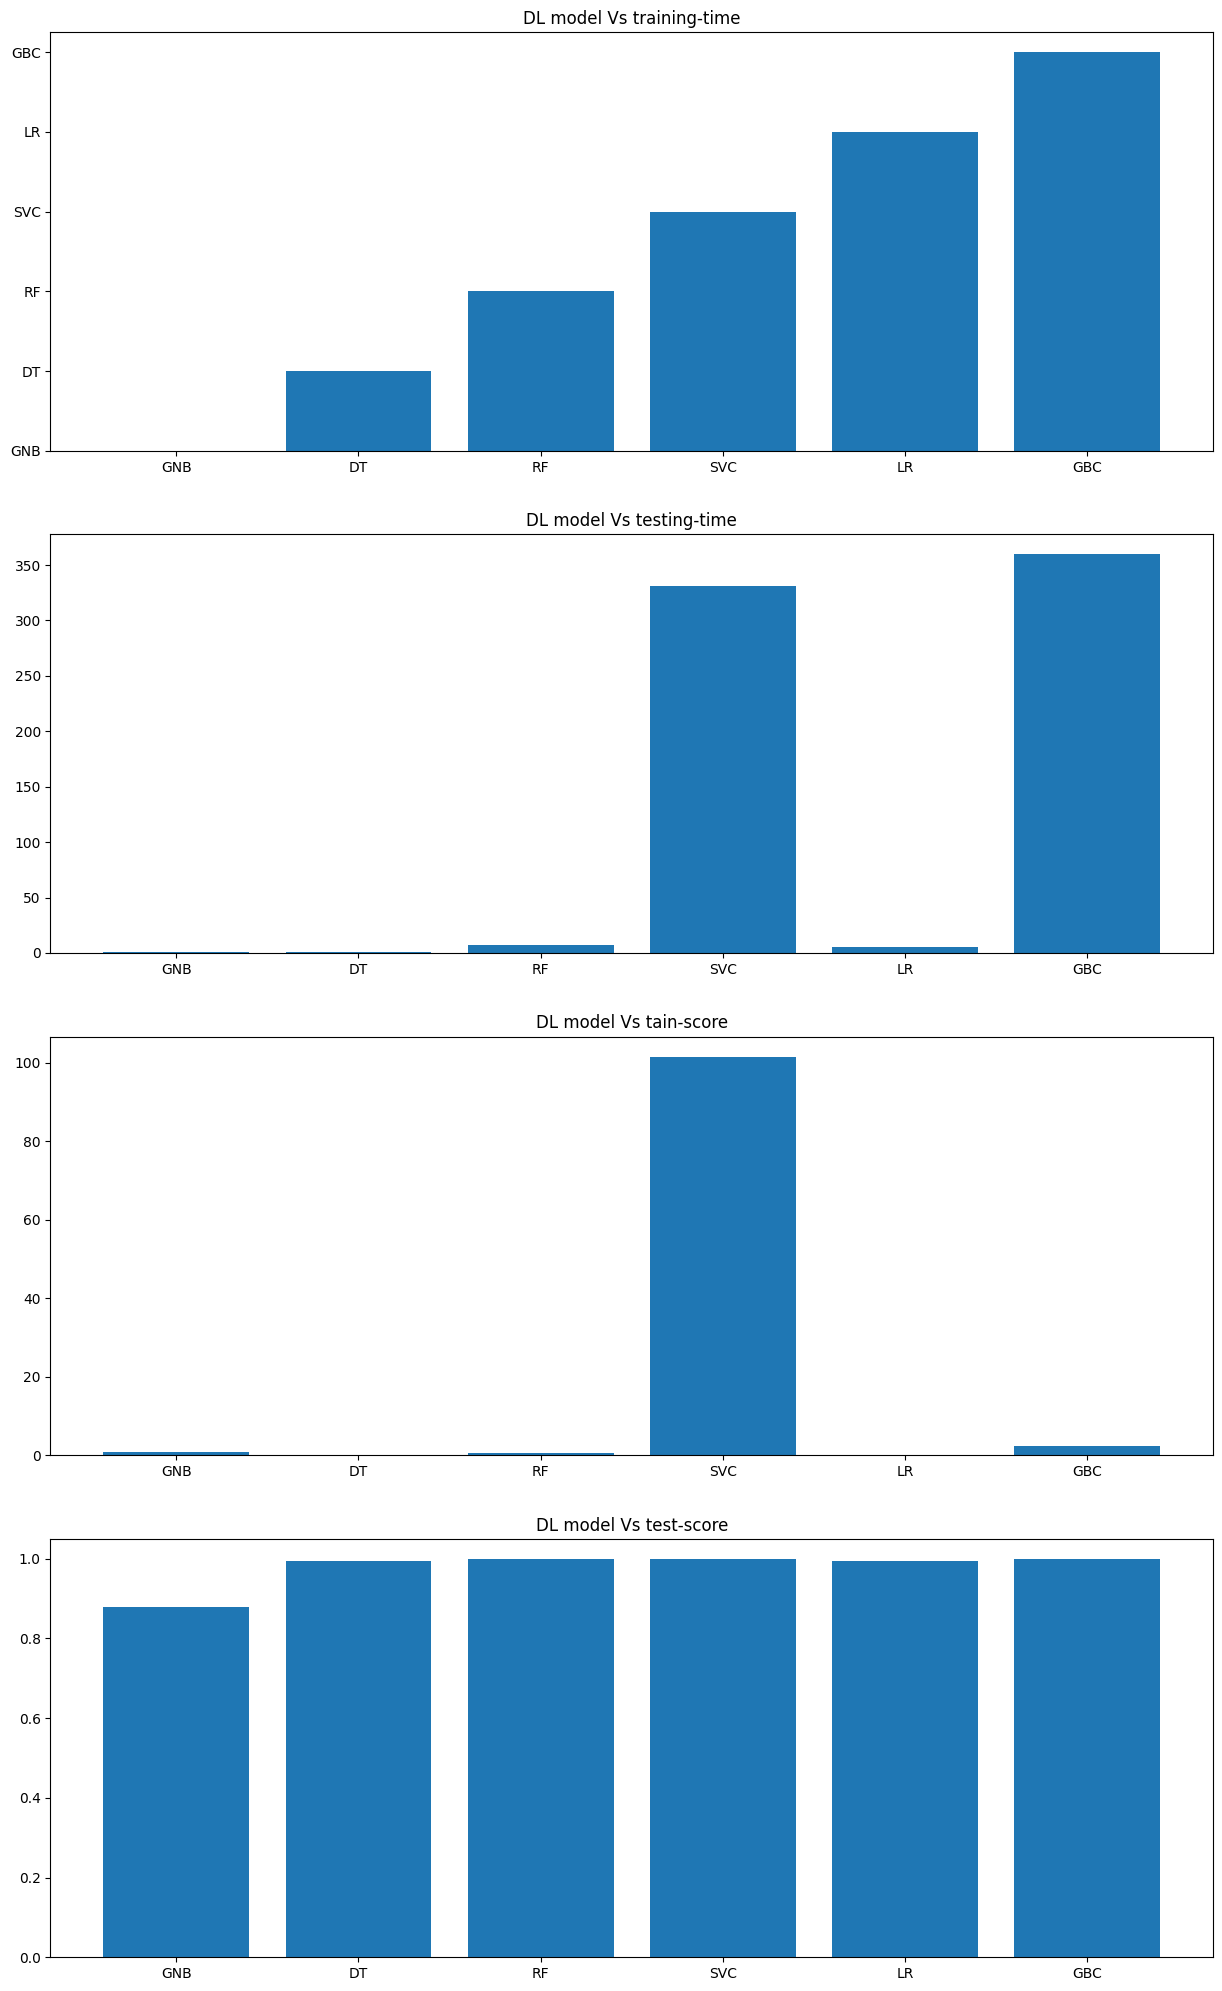

In [26]:
clfg = GaussianNB()
obj.eval_model(clfg, 'GNB')

clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
obj.eval_model(clfd, 'DT')

clfr = RandomForestClassifier(n_estimators = 30)
obj.eval_model(clfr, 'RF')

clfs = SVC(gamma = 'scale')
obj.eval_model(clfs, 'SVC')

clfl = LogisticRegression(max_iter = 1200000)
obj.eval_model(clfl, 'LR')

clfgb = GradientBoostingClassifier(random_state = 0)
obj.eval_model(clfgb, 'GBC')

obj.eval_graph()